In [1]:
%cd ..

/Users/maxschettewi/PycharmProjects/HPML Final Project


/Users/maxschettewi/PycharmProjects/HPML Final Project/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import zipfile
import os

# Unzip into data/raw
zip_name = "data/raw/LOBSTER_SampleFile_AAPL_2012-06-21_10.zip"
with zipfile.ZipFile(zip_name, "r") as z:
    z.extractall("data/raw")

print("data/raw contains:", os.listdir("data/raw"))

# Pick out the orderbook and message file names automatically
files_in_raw = os.listdir("data/raw")
RAW_ORDERBOOK_NAME = [f for f in files_in_raw if "orderbook" in f][0]
RAW_MESSAGE_NAME = [f for f in files_in_raw if "message" in f][0]

RAW_ORDERBOOK_PATH = f"data/raw/{RAW_ORDERBOOK_NAME}"
RAW_MESSAGE_PATH = f"data/raw/{RAW_MESSAGE_NAME}"
OUT_PATH = "data/processed/aapl_lobster_balanced.pt"

print("Orderbook path:", RAW_ORDERBOOK_PATH)
print("Message path:", RAW_MESSAGE_PATH)
print("Will save to:", OUT_PATH)

data/raw contains: ['LOBSTER_SampleFile_AAPL_2012-06-21_10.zip', 'LOBSTER_SampleFiles_ReadMe.txt', 'AAPL_2012-06-21_34200000_57600000_orderbook_10.csv', 'AAPL_2012-06-21_34200000_57600000_message_10.csv']
Orderbook path: data/raw/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv
Message path: data/raw/AAPL_2012-06-21_34200000_57600000_message_10.csv
Will save to: data/processed/aapl_lobster_balanced.pt


In [3]:
import numpy as np
import pandas as pd
import torch

from src.lob.data.preprocess import (
    compute_normalization,
    make_window_labels_balanced,
    build_split_indices,
)

# Process data with balanced labels
window_size = 100
horizon = 10

print(f"Loading orderbook from: {RAW_ORDERBOOK_PATH}")
ob = pd.read_csv(RAW_ORDERBOOK_PATH, header=None).values.astype(np.float32)
N, F = ob.shape
print(f"Orderbook shape: N={N}, F={F}")

# Normalize
mean, std = compute_normalization(ob, train_frac_for_stats=0.7)
ob_norm = (ob - mean) / std

# Create BALANCED labels using percentiles
seq_labels = make_window_labels_balanced(
    orderbook=ob,
    window_size=window_size,
    horizon=horizon,
    up_percentile=67,    # Top 33% = up
    down_percentile=33,  # Bottom 33% = down
)
M = seq_labels.shape[0]
print(f"Number of valid windows (M) = {M}")

# Split data
train_idx, val_idx, test_idx = build_split_indices(
    num_windows=M,
    train_frac=0.7,
    val_frac=0.15,
    mode="chronological",
    seed=42,
)
print(f"Split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# Save processed data
obj = {
    "lob": torch.from_numpy(ob_norm),
    "seq_labels": torch.from_numpy(seq_labels),
    "window_size": window_size,
    "horizon": horizon,
    "train_indices": torch.from_numpy(train_idx),
    "val_indices": torch.from_numpy(val_idx),
    "test_indices": torch.from_numpy(test_idx),
    "mean": torch.from_numpy(mean),
    "std": torch.from_numpy(std),
}

Loading orderbook from: data/raw/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv
Orderbook shape: N=400391, F=40

BALANCED LABEL DISTRIBUTION
  Class 0: 129,507 (32.4%)
  Class 1: 145,059 (36.2%)
  Class 2: 125,716 (31.4%)
  Up threshold: 0.000000
  Down threshold: 0.000000

Number of valid windows (M) = 400282
Split sizes: train=280197, val=60042, test=60043



KeyboardInterrupt



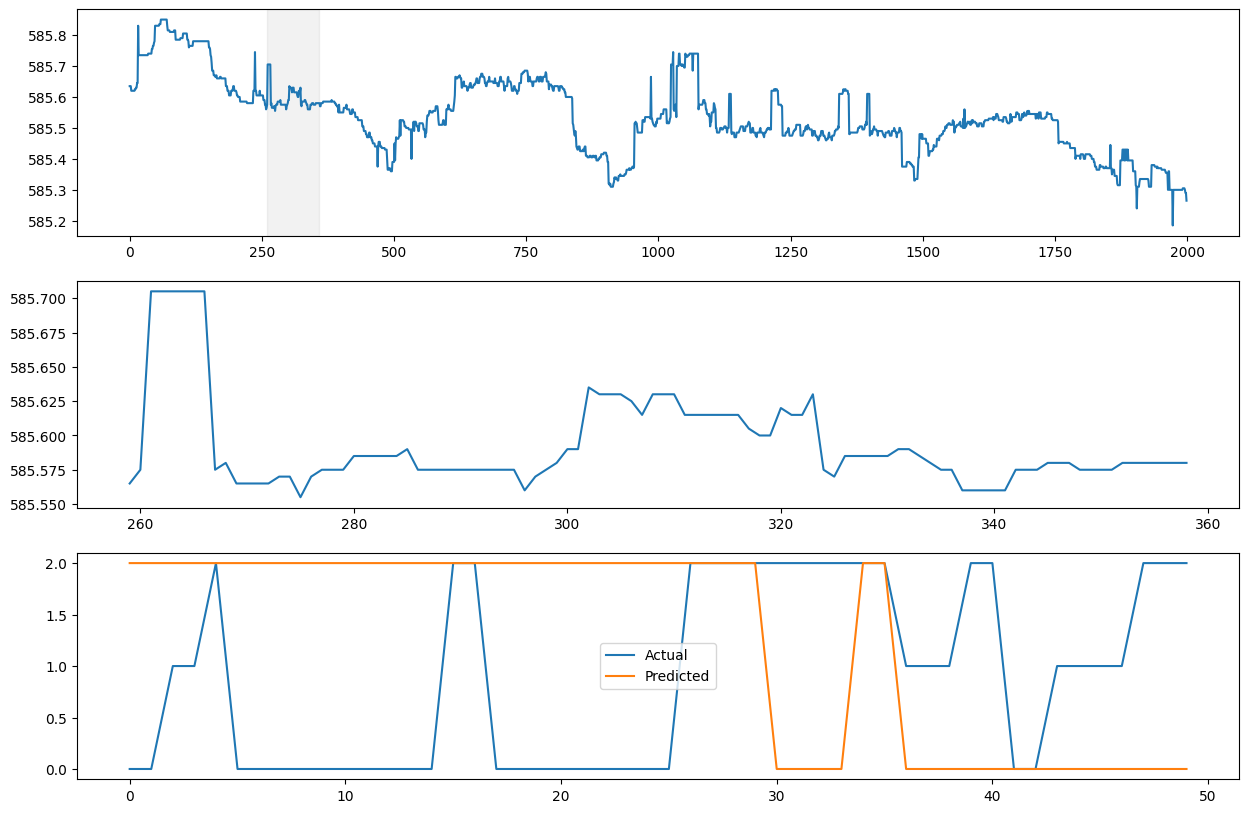

In [4]:
import torch
from src.lob.data.dataset import get_datasets
from src.lob.models.transformer import LOBTransformer, ModelConfig
from src.lob.visualize.stream import visualize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load("checkpoints/transformer_balanced.pt", map_location=device)

state_dict = ckpt["model_state_dict"]
if any(k.startswith("_orig_mod.") for k in state_dict):
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}

config = ModelConfig.base()
model = LOBTransformer(config)
model.load_state_dict(state_dict)
model.to(device).eval()

train_dataset, _, _ = get_datasets()
visualize(model=model, obj=obj)
